# Notebook 04: Model Development & Optimization

Advanced model development, hyperparameter tuning, and performance optimization using the feature engineered dataset from notebook 03.

## 1. Setup and Data Loading

### 1.1 Library Imports

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin, clone

# Advanced Models
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Hyperparameter Optimization
import optuna
from optuna.pruners import MedianPruner

# Progress tracking and utilities
from tqdm import tqdm
import joblib
import time
from scipy.optimize import minimize

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries loaded successfully")

Libraries loaded successfully


### 1.2 Data Loading and Validation
Load the feature engineered datasets from notebook 03 and validate their integrity by checking for missing values, infinite values, and data types.

In [3]:
# Load processed datasets
X_train = pd.read_csv('../data/processed/X_train_final.csv')
X_test = pd.read_csv('../data/processed/X_test_final.csv')
target_data = pd.read_csv('../data/processed/y_train_final.csv')

print("\n" + "="*60)
print("Data Import Summary:")
print(f"Features available: {X_train.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print("="*60)

# Extract log-transformed target
y_log = target_data['SalePrice']

print(f"\nTarget Variable Statistics:")
print(f"  Shape: {y_log.shape}")
print(f"  Mean: {y_log.mean():.4f}")
print(f"  Std: {y_log.std():.4f}")
print(f"  Range: {y_log.min():.4f} - {y_log.max():.4f}")

# Data quality validation
print("\nData Quality Check:")
print(f"Missing values in X_train: {X_train.isnull().sum().sum()}")
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")
print(f"Missing values in target: {y_log.isnull().sum()}")

# Check for infinite values
inf_train = np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()
inf_test = np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum()
print(f"Infinite values in X_train: {inf_train}")
print(f"Infinite values in X_test: {inf_test}")


Data Import Summary:
Features available: 191
Training samples: 1458
Test samples: 1459

Target Variable Statistics:
  Shape: (1458,)
  Mean: 12.0240
  Std: 0.3997
  Range: 10.4602 - 13.5345

Data Quality Check:
Missing values in X_train: 0
Missing values in X_test: 0
Missing values in target: 0
Infinite values in X_train: 0
Infinite values in X_test: 0


191 features has been loaded across 1458 training and 1459 test samples. Data quality validation confirms zero missing values and no infinite values, indicating clean preprocessed data ready for modeling.

### 1.3 Train-Validation Split
Create a holdout validation set by reserving 20% of training data for final model evaluation, providing an unbiased estimate of performance before touching the test set.

In [4]:
# Create train-validation split
X_train_split, X_val, y_train, y_val = train_test_split(
    X_train, y_log, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=None
)

print(f"\nTrain-Validation Split:")
print(f"  Training set: {X_train_split.shape[0]} samples")
print(f"  Validation set: {X_val.shape[0]} samples")
print(f"  Features: {X_train_split.shape[1]}")


Train-Validation Split:
  Training set: 1166 samples
  Validation set: 292 samples
  Features: 191


Created training split with 1166 samples and validation split with 292 samples, maintaining the same 191 features for model development.

## 2. Baseline Model Development

### 2.1 Baseline Models
Define baseline models, linear (Ridge, Lasso, ElasticNet), tree-based (RandomForest, GradientBoosting), and boosting models (XGBoost, CatBoost, LightGBM), that represent different algorithmic approaches

In [5]:
# Define baseline models
baseline_models = {
    'Ridge': Ridge(random_state=RANDOM_STATE),
    'Lasso': Lasso(random_state=RANDOM_STATE),
    'ElasticNet': ElasticNet(random_state=RANDOM_STATE),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
    'XGBoost': XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    'CatBoost': CatBoostRegressor(random_state=RANDOM_STATE, verbose=False),
    'LightGBM': LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
}

print("Baseline Models Initialized:")
for name, model in baseline_models.items():
    print(f"  - {name}: {type(model).__name__}")

Baseline Models Initialized:
  - Ridge: Ridge
  - Lasso: Lasso
  - ElasticNet: ElasticNet
  - RandomForest: RandomForestRegressor
  - GradientBoosting: GradientBoostingRegressor
  - XGBoost: XGBRegressor
  - CatBoost: CatBoostRegressor
  - LightGBM: LGBMRegressor


8 baseline models has been initialized.

### 2.2 Cross-Validation Framework
Set up a 5-fold cross-validation strategy that ensures reliable performance estimates. Each model will be evaluated using the same CV strategy for fair comparison.

In [6]:
# Cross-validation setup
cv_folds = 5
cv_strategy = KFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model_cv(model, X, y, cv_strategy, model_name="Model"):
    """
    Evaluate model using cross-validation
    
    Returns comprehensive performance metrics including mean and std of RMSE
    """
    print(f"Evaluating {model_name}...")
    
    # Perform cross-validation
    cv_scores = cross_val_score(
        model, X, y, 
        cv=cv_strategy, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    # Convert to RMSE
    cv_rmse_scores = np.sqrt(-cv_scores)
    
    results = {
        'cv_rmse_scores': cv_rmse_scores,
        'cv_rmse_mean': cv_rmse_scores.mean(),
        'cv_rmse_std': cv_rmse_scores.std(),
        'model': model
    }
    
    print(f"  RMSE: {results['cv_rmse_mean']:.4f} (+/- {results['cv_rmse_std']:.4f})")
    
    return results

print("Cross-validation framework ready")

Cross-validation framework ready


The 5-fold cross-validation framework has been established with evaluation function that returns mean RMSE, standard deviation, and model objects.

### 2.3 Baseline Model Evaluation
Conduct baseline evaluations to establish initial performance benchmarks and identify the most promising algorithms for further tuning through systematic cross-validation.

In [7]:
print("\n" + "="*80)
print("BASELINE MODEL EVALUATION")
print("="*80)

baseline_results = {}

# Evaluate each baseline model
for name, model in baseline_models.items():
    try:
        result = evaluate_model_cv(model, X_train_split, y_train, cv_strategy, name)
        baseline_results[name] = result
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")
        continue

# Display results in order of performance
print(f"\n{'Model':<15} {'CV RMSE':<12} {'CV Std':<10}")
print("-"*40)
for name, result in sorted(baseline_results.items(), key=lambda x: x[1]['cv_rmse_mean']):
    print(f"{name:<15} {result['cv_rmse_mean']:<12.4f} {result['cv_rmse_std']:<10.4f}")

# Identify best baseline
best_baseline = min(baseline_results.items(), key=lambda x: x[1]['cv_rmse_mean'])
print(f"\nBest Baseline Model: {best_baseline[0]} (RMSE: {best_baseline[1]['cv_rmse_mean']:.4f})")


BASELINE MODEL EVALUATION
Evaluating Ridge...
  RMSE: 0.1218 (+/- 0.0089)
Evaluating Lasso...
  RMSE: 0.3203 (+/- 0.0253)
Evaluating ElasticNet...
  RMSE: 0.3174 (+/- 0.0248)
Evaluating RandomForest...
  RMSE: 0.1418 (+/- 0.0095)
Evaluating GradientBoosting...
  RMSE: 0.1281 (+/- 0.0113)
Evaluating XGBoost...
  RMSE: 0.1419 (+/- 0.0082)
Evaluating CatBoost...
  RMSE: 0.1166 (+/- 0.0099)
Evaluating LightGBM...
  RMSE: 0.1309 (+/- 0.0088)

Model           CV RMSE      CV Std    
----------------------------------------
CatBoost        0.1166       0.0099    
Ridge           0.1218       0.0089    
GradientBoosting 0.1281       0.0113    
LightGBM        0.1309       0.0088    
RandomForest    0.1418       0.0095    
XGBoost         0.1419       0.0082    
ElasticNet      0.3174       0.0248    
Lasso           0.3203       0.0253    

Best Baseline Model: CatBoost (RMSE: 0.1166)


Completed baseline evaluation across 8 algorithms. The best performing baseline model achieved an RMSE of 0.1166 with CatBoos tdemonstrating the strongest initial performance. Performance spread ranged from 0.1166 to 0.3203, indicating significant algorithmic differences.

## 3. Hyperparameter Optimization
Perform individual hyperparameter optimization for each model using Optuna's Bayesian optimization framework. Each model receives customized parameter spaces and trial counts based on complexity, allowing for model-specific optimization strategies and detailed progress tracking.

### 3.1 Ridge Regression Optimization
Optimize Ridge regression with focus on regularization parameter, using fewer trials due to the simple parameter space

In [8]:
def objective_ridge(trial):
    """Objective function for Ridge hyperparameter optimization"""
    alpha = trial.suggest_float('alpha', 1e-4, 1.0, log=True)
    model = Ridge(alpha=alpha, random_state=RANDOM_STATE)
    
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("Optimizing Ridge...")
study_ridge = optuna.create_study(direction='minimize', study_name='ridge_optimization')
study_ridge.optimize(objective_ridge, n_trials=30, show_progress_bar=True)

print(f"Best Ridge RMSE: {study_ridge.best_value:.4f}")
best_ridge_params = study_ridge.best_params
best_ridge = Ridge(**best_ridge_params, random_state=RANDOM_STATE)
ridge_result = evaluate_model_cv(best_ridge, X_train_split, y_train, cv_strategy, "Ridge_Optimized")
ridge_result['best_params'] = best_ridge_params

print(f"  Baseline RMSE (CV): {baseline_results['Ridge']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_ridge.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {ridge_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['Ridge']['cv_rmse_mean'] - ridge_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 15:34:48,295] A new study created in memory with name: ridge_optimization


Optimizing Ridge...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-15 15:34:48,475] Trial 0 finished with value: 0.13520377102507894 and parameters: {'alpha': 0.0010125578098238882}. Best is trial 0 with value: 0.13520377102507894.
[I 2025-07-15 15:34:48,616] Trial 1 finished with value: 0.13558975978594387 and parameters: {'alpha': 0.00026174581206313415}. Best is trial 0 with value: 0.13520377102507894.
[I 2025-07-15 15:34:48,758] Trial 2 finished with value: 0.1266491657014568 and parameters: {'alpha': 0.09867766816892906}. Best is trial 2 with value: 0.1266491657014568.
[I 2025-07-15 15:34:48,887] Trial 3 finished with value: 0.13424459625461946 and parameters: {'alpha': 0.003186175451099461}. Best is trial 2 with value: 0.1266491657014568.
[I 2025-07-15 15:34:49,017] Trial 4 finished with value: 0.13340075718242597 and parameters: {'alpha': 0.005565624057422792}. Best is trial 2 with value: 0.1266491657014568.
[I 2025-07-15 15:34:49,090] Trial 5 finished with value: 0.13561595575926716 and parameters: {'alpha': 0.0002130033123543967}. 

Minimal or no improvement from hyperparameter optimization; baseline Ridge model already performs close to optimal under cross-validation.

### 3.2 Lasso Regression Optimization
Optimize Lasso regression with regularization parameter tuning for feature selection capabilities.

In [9]:
def objective_lasso(trial):
    """Objective function for Lasso hyperparameter optimization"""
    alpha = trial.suggest_float('alpha', 1e-4, 1.0, log=True)
    model = Lasso(alpha=alpha, random_state=RANDOM_STATE, max_iter=3000)
    
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("\nOptimizing Lasso...")
study_lasso = optuna.create_study(direction='minimize', study_name='lasso_optimization')
study_lasso.optimize(objective_lasso, n_trials=30, show_progress_bar=True)

print(f"Best Lasso RMSE: {study_lasso.best_value:.4f}")
best_lasso_params = study_lasso.best_params
best_lasso = Lasso(**best_lasso_params, random_state=RANDOM_STATE, max_iter=3000)
lasso_result = evaluate_model_cv(best_lasso, X_train_split, y_train, cv_strategy, "Lasso_Optimized")
lasso_result['best_params'] = best_lasso_params

print(f"  Baseline RMSE (CV): {baseline_results['Lasso']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_lasso.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {lasso_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['Lasso']['cv_rmse_mean'] - lasso_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 15:35:13,831] A new study created in memory with name: lasso_optimization



Optimizing Lasso...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-15 15:35:14,085] Trial 0 finished with value: 0.1203782471259587 and parameters: {'alpha': 0.0012020982712995876}. Best is trial 0 with value: 0.1203782471259587.
[I 2025-07-15 15:35:14,267] Trial 1 finished with value: 0.14077868708548372 and parameters: {'alpha': 0.007378442729924348}. Best is trial 0 with value: 0.1203782471259587.
[I 2025-07-15 15:35:14,397] Trial 2 finished with value: 0.1812099932873769 and parameters: {'alpha': 0.03728635507961505}. Best is trial 0 with value: 0.1203782471259587.
[I 2025-07-15 15:35:14,553] Trial 3 finished with value: 0.15715939874046073 and parameters: {'alpha': 0.01614818014233351}. Best is trial 0 with value: 0.1203782471259587.
[I 2025-07-15 15:35:14,699] Trial 4 finished with value: 0.2005186150404107 and parameters: {'alpha': 0.06258841351936001}. Best is trial 0 with value: 0.1203782471259587.
[I 2025-07-15 15:35:14,832] Trial 5 finished with value: 0.19034783051917548 and parameters: {'alpha': 0.046362787622075956}. Best is t

Large performance gain after tuning. Lasso benefits considerably from optimization, reducing RMSE by over 0.20.

### 3.3 ElasticNet Optimization
Optimize ElasticNet with both regularization strength and L1/L2 ratio parameters.

In [10]:
def objective_elasticnet(trial):
    """Objective function for ElasticNet hyperparameter optimization"""
    alpha = trial.suggest_float('alpha', 1e-4, 1.0, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.9)
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=RANDOM_STATE, max_iter=3000)
    
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("\nOptimizing ElasticNet...")
study_elasticnet = optuna.create_study(direction='minimize', study_name='elasticnet_optimization')
study_elasticnet.optimize(objective_elasticnet, n_trials=30, show_progress_bar=True)

print(f"Best ElasticNet RMSE: {study_elasticnet.best_value:.4f}")
best_elasticnet_params = study_elasticnet.best_params
best_elasticnet = ElasticNet(**best_elasticnet_params, random_state=RANDOM_STATE, max_iter=3000)
elasticnet_result = evaluate_model_cv(best_elasticnet, X_train_split, y_train, cv_strategy, "ElasticNet_Optimized")
elasticnet_result['best_params'] = best_elasticnet_params

print(f"  Baseline RMSE (CV): {baseline_results['ElasticNet']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_elasticnet.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {elasticnet_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['ElasticNet']['cv_rmse_mean'] - elasticnet_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 15:35:20,618] A new study created in memory with name: elasticnet_optimization



Optimizing ElasticNet...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-15 15:35:20,776] Trial 0 finished with value: 0.16382359728303844 and parameters: {'alpha': 0.030320534242929267, 'l1_ratio': 0.6399974069355291}. Best is trial 0 with value: 0.16382359728303844.
[I 2025-07-15 15:35:20,908] Trial 1 finished with value: 0.1816146663334864 and parameters: {'alpha': 0.055908366212521245, 'l1_ratio': 0.6607376201796784}. Best is trial 0 with value: 0.16382359728303844.
[I 2025-07-15 15:35:21,053] Trial 2 finished with value: 0.1797300075757017 and parameters: {'alpha': 0.11958544496029479, 'l1_ratio': 0.271665290071691}. Best is trial 0 with value: 0.16382359728303844.
[I 2025-07-15 15:35:21,240] Trial 3 finished with value: 0.1185459158898347 and parameters: {'alpha': 0.0011316205200236561, 'l1_ratio': 0.5934596814732499}. Best is trial 3 with value: 0.1185459158898347.
[I 2025-07-15 15:35:21,384] Trial 4 finished with value: 0.1538774329124556 and parameters: {'alpha': 0.06126632562319973, 'l1_ratio': 0.2039837066362029}. Best is trial 3 with 

The RMSE improved from 0.3174 (baseline cross-validation) to 0.1175 (optimized model evaluated via cross-validation), indicating a performance gain of 0.1999. This suggests that the initial model benefited substantially from hyperparameter tuning.

### 3.4 Random Forest Optimization
Optimize Random Forest with tree-specific parameters and ensemble size tuning.

In [11]:
def objective_randomforest(trial):
    """Objective function for Random Forest hyperparameter optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
    
    model = RandomForestRegressor(**params)
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=1)  # Single job to avoid conflicts
    return np.sqrt(-cv_scores.mean())

print("\nOptimizing Random Forest...")
study_rf = optuna.create_study(direction='minimize', study_name='rf_optimization')
study_rf.optimize(objective_randomforest, n_trials=50, show_progress_bar=True)

print(f"Best Random Forest RMSE: {study_rf.best_value:.4f}")
best_rf_params = study_rf.best_params
best_rf = RandomForestRegressor(**best_rf_params, random_state=RANDOM_STATE, n_jobs=-1)
rf_result = evaluate_model_cv(best_rf, X_train_split, y_train, cv_strategy, "RandomForest_Optimized")
rf_result['best_params'] = best_rf_params

print(f"  Baseline RMSE (CV): {baseline_results['RandomForest']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_rf.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {rf_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['RandomForest']['cv_rmse_mean'] - rf_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 15:35:27,009] A new study created in memory with name: rf_optimization



Optimizing Random Forest...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-15 15:35:27,821] Trial 0 finished with value: 0.161980059612074 and parameters: {'n_estimators': 340, 'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.161980059612074.
[I 2025-07-15 15:35:28,405] Trial 1 finished with value: 0.17550496220685327 and parameters: {'n_estimators': 255, 'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.161980059612074.
[I 2025-07-15 15:35:30,466] Trial 2 finished with value: 0.14234170429875087 and parameters: {'n_estimators': 419, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 2 with value: 0.14234170429875087.
[I 2025-07-15 15:35:32,372] Trial 3 finished with value: 0.1468283217299734 and parameters: {'n_estimators': 412, 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 2 with value: 0.1423417042987508

A very slight improvement was observed after hyperparameter tuning: RMSE decreased from 0.1418 (baseline CV) to 0.1412 (optimized CV evaluation). Although the difference is small (0.0005), it indicates a modest gain in predictive accuracy through tuning.

### 3.5 Gradient Boosting Optimization
Optimize Gradient Boosting with learning rate, tree depth, and ensemble parameters.

In [12]:
def objective_gradientboosting(trial):
    """Objective function for Gradient Boosting hyperparameter optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'random_state': RANDOM_STATE
    }
    
    model = GradientBoostingRegressor(**params)
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("\nOptimizing Gradient Boosting...")
study_gb = optuna.create_study(direction='minimize', study_name='gradientboosting_optimization')
study_gb.optimize(objective_gradientboosting, n_trials=60, show_progress_bar=True)

print(f"Best Gradient Boosting RMSE: {study_gb.best_value:.4f}")
best_gb_params = study_gb.best_params
best_gb = GradientBoostingRegressor(**best_gb_params, random_state=RANDOM_STATE)
gb_result = evaluate_model_cv(best_gb, X_train_split, y_train, cv_strategy, "GradientBoosting_Optimized")
gb_result['best_params'] = best_gb_params

print(f"  Baseline RMSE (CV): {baseline_results['GradientBoosting']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_gb.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {gb_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['GradientBoosting']['cv_rmse_mean'] - gb_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 15:36:19,786] A new study created in memory with name: gradientboosting_optimization



Optimizing Gradient Boosting...


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-07-15 15:36:20,389] Trial 0 finished with value: 0.145380816091639 and parameters: {'n_estimators': 52, 'learning_rate': 0.13819871581319598, 'max_depth': 8, 'subsample': 0.9253970048327695}. Best is trial 0 with value: 0.145380816091639.
[I 2025-07-15 15:36:21,570] Trial 1 finished with value: 0.14931585156944183 and parameters: {'n_estimators': 102, 'learning_rate': 0.2988646562044713, 'max_depth': 8, 'subsample': 0.854819651832775}. Best is trial 0 with value: 0.145380816091639.
[I 2025-07-15 15:36:22,896] Trial 2 finished with value: 0.14111845594464184 and parameters: {'n_estimators': 133, 'learning_rate': 0.04484878251994911, 'max_depth': 7, 'subsample': 0.9715708677935734}. Best is trial 2 with value: 0.14111845594464184.
[I 2025-07-15 15:36:23,346] Trial 3 finished with value: 0.12917577345035194 and parameters: {'n_estimators': 54, 'learning_rate': 0.23173238215869657, 'max_depth': 3, 'subsample': 0.8173520035000198}. Best is trial 3 with value: 0.12917577345035194.
[I

Gradient Boosting showed a modest improvement through optimization, with RMSE decreasing from 0.1281 (baseline CV) to 0.1227 (optimized CV evaluation), yielding a gain of 0.0054. This suggests that hyperparameter tuning provided a measurable but limited enhancement in performance.

### 3.6 XGBoost Optimization
Optimize XGBoost with comprehensive parameter tuning including regularization and tree structure parameters.

In [13]:
def objective_xgboost(trial):
    """Objective function for XGBoost hyperparameter optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 0.8),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 5),
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    model = XGBRegressor(**params)
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=1)
    return np.sqrt(-cv_scores.mean())

print("\nOptimizing XGBoost...")
study_xgb = optuna.create_study(direction='minimize', study_name='xgb_optimization')
study_xgb.optimize(objective_xgboost, n_trials=75, show_progress_bar=True)

print(f"Best XGBoost RMSE: {study_xgb.best_value:.4f}")
best_xgb_params = study_xgb.best_params
best_xgb = XGBRegressor(**best_xgb_params, random_state=RANDOM_STATE, n_jobs=-1, verbosity=0)
xgb_result = evaluate_model_cv(best_xgb, X_train_split, y_train, cv_strategy, "XGBoost_Optimized")
xgb_result['best_params'] = best_xgb_params

print(f"  Baseline RMSE (CV): {baseline_results['XGBoost']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_xgb.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {xgb_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['XGBoost']['cv_rmse_mean'] - xgb_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 15:37:05,537] A new study created in memory with name: xgb_optimization



Optimizing XGBoost...


  0%|          | 0/75 [00:00<?, ?it/s]

[I 2025-07-15 15:37:13,990] Trial 0 finished with value: 0.1306995152490078 and parameters: {'n_estimators': 1768, 'learning_rate': 0.19485559534533878, 'colsample_bytree': 0.61642047930317, 'subsample': 0.712767011364308, 'min_child_weight': 3}. Best is trial 0 with value: 0.1306995152490078.
[I 2025-07-15 15:37:40,223] Trial 1 finished with value: 0.12138309870597618 and parameters: {'n_estimators': 3446, 'learning_rate': 0.007925221374941328, 'colsample_bytree': 0.6429393749395897, 'subsample': 0.7790851464336763, 'min_child_weight': 4}. Best is trial 1 with value: 0.12138309870597618.
[I 2025-07-15 15:38:03,687] Trial 2 finished with value: 0.11706352271993893 and parameters: {'n_estimators': 3156, 'learning_rate': 0.00952940220125351, 'colsample_bytree': 0.6173107436842491, 'subsample': 0.4714658622489154, 'min_child_weight': 4}. Best is trial 2 with value: 0.11706352271993893.
[I 2025-07-15 15:38:29,260] Trial 3 finished with value: 0.12739574127569375 and parameters: {'n_estimat

XGBoost demonstrated a clear improvement following optimization, with RMSE dropping from 0.1419 (baseline CV) to 0.1148 (optimized CV evaluation), resulting in a performance gain of 0.0270. This indicates that hyperparameter tuning had a strong positive impact on model accuracy.

### 3.7 CatBoost Optimization
Optimize CatBoost with categorical feature handling and gradient boosting parameters.


In [14]:
def objective_catboost(trial):
    """Objective function for CatBoost hyperparameter optimization"""
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 8000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 7),
        'eval_metric': 'RMSE',
        'random_state': RANDOM_STATE,
        'verbose': False
    }
    
    model = CatBoostRegressor(**params)
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("\nOptimizing CatBoost...")
study_catboost = optuna.create_study(direction='minimize', study_name='catboost_optimization')
study_catboost.optimize(objective_catboost, n_trials=75, show_progress_bar=True)

print(f"Best CatBoost RMSE: {study_catboost.best_value:.4f}")
best_catboost_params = study_catboost.best_params
best_catboost = CatBoostRegressor(**best_catboost_params, random_state=RANDOM_STATE, verbose=False)
catboost_result = evaluate_model_cv(best_catboost, X_train_split, y_train, cv_strategy, "CatBoost_Optimized")
catboost_result['best_params'] = best_catboost_params

print(f"  Baseline RMSE (CV): {baseline_results['CatBoost']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_catboost.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {catboost_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['CatBoost']['cv_rmse_mean'] - catboost_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 16:05:31,984] A new study created in memory with name: catboost_optimization



Optimizing CatBoost...


  0%|          | 0/75 [00:00<?, ?it/s]

[I 2025-07-15 16:05:47,507] Trial 0 finished with value: 0.11596915972900862 and parameters: {'iterations': 6962, 'learning_rate': 0.00662087967314295, 'depth': 6}. Best is trial 0 with value: 0.11596915972900862.
[I 2025-07-15 16:05:50,638] Trial 1 finished with value: 0.12049666947852163 and parameters: {'iterations': 4838, 'learning_rate': 0.14172217037341484, 'depth': 3}. Best is trial 0 with value: 0.11596915972900862.
[I 2025-07-15 16:05:56,305] Trial 2 finished with value: 0.11619565845250399 and parameters: {'iterations': 2399, 'learning_rate': 0.02156408563732035, 'depth': 6}. Best is trial 0 with value: 0.11596915972900862.
[I 2025-07-15 16:05:58,782] Trial 3 finished with value: 0.11689034315964737 and parameters: {'iterations': 3516, 'learning_rate': 0.05378539154372889, 'depth': 3}. Best is trial 0 with value: 0.11596915972900862.
[I 2025-07-15 16:06:09,918] Trial 4 finished with value: 0.11485906509796444 and parameters: {'iterations': 7796, 'learning_rate': 0.00801955722

CatBoost showed a modest improvement after optimization, with the RMSE decreasing from 0.1166 (baseline CV) to 0.1143 (optimized CV evaluation). The improvement of 0.0023 suggests that tuning had a small but measurable effect on performance.

### 3.8 LightGBM Optimization
Optimize LightGBM with gradient boosting and leaf-wise tree growth parameters.

In [15]:
def objective_lightgbm(trial):
    """Objective function for LightGBM hyperparameter optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbose': -1
    }
    
    model = LGBMRegressor(**params)
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=1)
    return np.sqrt(-cv_scores.mean())

print("\nOptimizing LightGBM...")
study_lightgbm = optuna.create_study(direction='minimize', study_name='lightgbm_optimization')
study_lightgbm.optimize(objective_lightgbm, n_trials=75, show_progress_bar=True)

print(f"Best LightGBM RMSE: {study_lightgbm.best_value:.4f}")
best_lightgbm_params = study_lightgbm.best_params
best_lightgbm = LGBMRegressor(**best_lightgbm_params, random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
lightgbm_result = evaluate_model_cv(best_lightgbm, X_train_split, y_train, cv_strategy, "LightGBM_Optimized")
lightgbm_result['best_params'] = best_lightgbm_params

print(f"  Baseline RMSE (CV): {baseline_results['LightGBM']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_lightgbm.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {lightgbm_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['LightGBM']['cv_rmse_mean'] - lightgbm_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 16:21:43,049] A new study created in memory with name: lightgbm_optimization



Optimizing LightGBM...


  0%|          | 0/75 [00:00<?, ?it/s]

[I 2025-07-15 16:21:48,180] Trial 0 finished with value: 0.17070600366190783 and parameters: {'n_estimators': 6700, 'max_depth': 4, 'learning_rate': 0.18771640917513788, 'subsample': 0.6781129208739136, 'colsample_bytree': 0.6121198123449142, 'min_child_samples': 88, 'reg_alpha': 9.82186871673033, 'reg_lambda': 5.901392379940298}. Best is trial 0 with value: 0.17070600366190783.
[I 2025-07-15 16:21:55,245] Trial 1 finished with value: 0.1297706048488239 and parameters: {'n_estimators': 1089, 'max_depth': 4, 'learning_rate': 0.008227863569129292, 'subsample': 0.6447207473228928, 'colsample_bytree': 0.3620055436905002, 'min_child_samples': 43, 'reg_alpha': 0.7065475216012482, 'reg_lambda': 0.12785758289728338}. Best is trial 1 with value: 0.1297706048488239.
[I 2025-07-15 16:22:06,305] Trial 2 finished with value: 0.1390059542407407 and parameters: {'n_estimators': 2198, 'max_depth': 14, 'learning_rate': 0.009604456082360081, 'subsample': 0.6884379623006328, 'colsample_bytree': 0.8232021

LightGBM demonstrated a noticeable improvement through optimization, reducing the RMSE from 0.1309 (baseline CV) to 0.1172 (optimized CV evaluation). The improvement of 0.0137 indicates that hyperparameter tuning contributed meaningfully to performance gains.

### 3.9 Optimization Results Summary
Collect all optimized results and create a comparison.

In [40]:
# Collect all optimized results
optimized_results = {
    'Ridge_Optimized': ridge_result,
    'Lasso_Optimized': lasso_result,
    'ElasticNet_Optimized': elasticnet_result,
    'RandomForest_Optimized': rf_result,
    'GradientBoosting_Optimized': gb_result,
    'XGBoost_Optimized': xgb_result,
    'CatBoost_Optimized': catboost_result,
    'LightGBM_Optimized': lightgbm_result
}


print(f"\n" + "="*80)
print("OPTIMIZATION RESULTS SUMMARY")
print("="*80)
print(f"{'Model':<20} {'Baseline RMSE':<15} {'Optimized RMSE':<15} {'Improvement':<12}")
print("-"*80)

for model_name in ['Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'GradientBoosting', 'XGBoost', 'CatBoost', 'LightGBM']:
    baseline_rmse = baseline_results[model_name]['cv_rmse_mean']
    optimized_rmse = optimized_results[f"{model_name}_Optimized"]['cv_rmse_mean']
    improvement = baseline_rmse - optimized_rmse
    print(f"{model_name:<20} {baseline_rmse:<15.4f} {optimized_rmse:<15.4f} {improvement:<12.4f}")

print(f"Models optimized: {len(optimized_results)}")


OPTIMIZATION RESULTS SUMMARY
Model                Baseline RMSE   Optimized RMSE  Improvement 
--------------------------------------------------------------------------------
Ridge                0.1218          0.1218          -0.0000     
Lasso                0.3203          0.1175          0.2029      
ElasticNet           0.3174          0.1175          0.1999      
RandomForest         0.1418          0.1412          0.0005      
GradientBoosting     0.1281          0.1227          0.0054      
XGBoost              0.1419          0.1148          0.0270      
CatBoost             0.1166          0.1143          0.0023      
LightGBM             0.1309          0.1172          0.0137      
Models optimized: 8


Among the eight optimized models, Lasso and ElasticNet showed the largest improvements with RMSE reductions of 0.2029 and 0.1999, respectively, suggesting that regularization played a significant role in reducing overfitting.
XGBoost and LightGBM also benefited from tuning, improving by 0.0270 and 0.0137, while GradientBoosting, CatBoost, and RandomForest saw more modest gains.
Ridge regression remained stable with no change in RMSE, indicating that its baseline configuration was already near optimal.

## 4. Ensemble Methods
### 4.1 Simple Ensemble (Equal Weighting)
Create the first ensemble by averaging predictions from the top 3 performing models. This approach combines different models that make different types of errors, with model diversity helping to reduce overfitting while capturing different patterns in the data.

In [42]:
print("\n" + "="*80)
print("ENSEMBLE METHODS")
print("="*80)

# Select top 4 models for ensembling
top_models = sorted(optimized_results.items(), key=lambda x: x[1]['cv_rmse_mean'])[:4]

print("Top 4 models selected for ensembling:")
for i, (name, result) in enumerate(top_models, 1):
    print(f"  {i}. {name}: {result['cv_rmse_mean']:.4f}")

# Get model objects
model_map = {
    'XGBoost': best_xgb,
    'CatBoost': best_catboost,
    'LightGBM': best_lightgbm,
    'RandomForest': best_rf,
    'Lasso': best_lasso,
    'ElasticNet': best_elasticnet
}

top_model_objects = [model_map[name.replace('_Optimized', '')] for name, _ in top_models]
top_model_names = [name for name, _ in top_models]

# Simple ensemble implementation
class SimpleEnsemble(BaseEstimator, RegressorMixin):
    """
    Simple ensemble that averages predictions from multiple models
    """
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.fitted_models_ = []
        for model in self.models:
            fitted_model = clone(model)
            fitted_model.fit(X, y)
            self.fitted_models_.append(fitted_model)
        return self
    
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.fitted_models_])
        return np.mean(predictions, axis=0)

# Create simple ensemble
simple_ensemble_models = top_model_objects
simple_ensemble = SimpleEnsemble(simple_ensemble_models)

# Calculate best individual model's RMSE
best_individual_rmse = top_models[0][1]['cv_rmse_mean']  # Lowest RMSE from top models

# Evaluate simple ensemble
simple_result = evaluate_model_cv(simple_ensemble, X_train_split, y_train, cv_strategy, "Simple_Ensemble")

# Add validation RMSE
simple_ensemble.fit(X_train_split, y_train)
simple_val_pred = simple_ensemble.predict(X_val)
simple_val_rmse = np.sqrt(mean_squared_error(y_val, simple_val_pred))
simple_result['val_rmse'] = simple_val_rmse

# Calculate percentage improvement over best individual model
ensemble_rmse = simple_result['cv_rmse_mean']
ensemble_improvement = (best_individual_rmse - ensemble_rmse) / best_individual_rmse * 100

# Save result
ensemble_results = {'Simple_Ensemble': simple_result}


print(f"  Best Individual RMSE: {best_individual_rmse:.4f}")
print(f"  Improvement over best individual model: {ensemble_improvement:.2f}%")



ENSEMBLE METHODS
Top 4 models selected for ensembling:
  1. CatBoost_Optimized: 0.1143
  2. XGBoost_Optimized: 0.1148
  3. LightGBM_Optimized: 0.1172
  4. Lasso_Optimized: 0.1175
Evaluating Simple_Ensemble...
  RMSE: 0.1117 (+/- 0.0100)
  Best Individual RMSE: 0.1143
  Improvement over best individual model: 2.31%


Created a simple ensemble from the top 4 performing models with equal weighting.
The ensemble achieved an RMSE of 0.1117, representing a 2.28% improvement over the best individual model (CatBoost_Optimized, RMSE: 0.1143).

### 4.2 Weighted Ensemble (Performance-Based Weighting)
Create a weighted ensemble where models receive weights proportional to their performance, calculated using inverse RMSE scores. For example, if Model A has RMSE=0.1 and Model B has RMSE=0.2, then Model A gets weight 1/0.1=10 and Model B gets weight 1/0.2=5, normalized to sum to 1.

In [45]:
# Weighted ensemble implementation
class WeightedEnsemble(BaseEstimator, RegressorMixin):
    """
    Weighted ensemble using performance-based weights
    """
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights
        
    def fit(self, X, y):
        self.fitted_models_ = []
        for model in self.models:
            fitted_model = clone(model)
            fitted_model.fit(X, y)
            self.fitted_models_.append(fitted_model)
        return self
    
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.fitted_models_])
        weighted_predictions = np.average(predictions, axis=0, weights=self.weights)
        return weighted_predictions

# Calculate performance-based weights
rmse_scores = [result['cv_rmse_mean'] for _, result in top_models]
weights = [1/rmse for rmse in rmse_scores]
weights = np.array(weights) / np.sum(weights)  # Normalize

print(f"\nEnsemble weights based on inverse RMSE:")
for i, ((name, _), weight) in enumerate(zip(top_models, weights)):
    print(f"  {name}: {weight:.3f}")

# Create weighted ensemble
weighted_ensemble = WeightedEnsemble(simple_ensemble_models, weights)

# Evaluate weighted ensemble
weighted_result = evaluate_model_cv(weighted_ensemble, X_train_split, y_train, cv_strategy, "Weighted_Ensemble")

# Add validation RMSE
weighted_ensemble.fit(X_train_split, y_train)
weighted_val_pred = weighted_ensemble.predict(X_val)
weighted_val_rmse = np.sqrt(mean_squared_error(y_val, weighted_val_pred))
weighted_result['val_rmse'] = weighted_val_rmse

ensemble_results['Weighted_Ensemble'] = weighted_result


Ensemble weights based on inverse RMSE:
  CatBoost_Optimized: 0.254
  XGBoost_Optimized: 0.252
  LightGBM_Optimized: 0.247
  Lasso_Optimized: 0.247
Evaluating Weighted_Ensemble...
  RMSE: 0.1117 (+/- 0.0101)


The weighted ensemble assigned higher importance to models with lower cross-validated RMSE, using inverse-RMSE weighting. CatBoost and XGBoost received slightly higher weights, but all four models contributed comparably. The final weighted ensemble achieved an RMSE of 0.1117 (± 0.0101), matching the performance of the simple average ensemble.

### 4.3 Stacking Ensemble (Meta-Learning)
Implement a stacking ensemble approach where a meta-learner (Ridge regression) learns how to combine predictions from base models. The base models make cross-validated predictions, then a meta-learner is trained to predict the target using these predictions as features.

In [46]:
# Stacking ensemble with Ridge meta-learner
stacking_ensemble = StackingRegressor(
    estimators=[(f"model_{i}", model) for i, model in enumerate(simple_ensemble_models)],
    final_estimator=Ridge(alpha=1.0),
    cv=3,
    n_jobs=-1
)

# Evaluate stacking ensemble
stacking_result = evaluate_model_cv(stacking_ensemble, X_train_split, y_train, cv_strategy, "Stacking_Ensemble")

# Add validation RMSE
stacking_ensemble.fit(X_train_split, y_train)
stacking_val_pred = stacking_ensemble.predict(X_val)
stacking_val_rmse = np.sqrt(mean_squared_error(y_val, stacking_val_pred))
stacking_result['val_rmse'] = stacking_val_rmse

ensemble_results['Stacking_Ensemble'] = stacking_result

# Display ensemble results
print("\n" + "="*70)
print("ENSEMBLE METHOD RESULTS")
print("="*70)
print(f"{'Method':<20} {'CV RMSE':<12} {'CV Std':<10} {'Val RMSE':<12}")
print("-"*70)
for name, result in sorted(ensemble_results.items(), key=lambda x: x[1]['cv_rmse_mean']):
    print(f"{name:<20} {result['cv_rmse_mean']:<12.4f} {result['cv_rmse_std']:<10.4f} {result['val_rmse']:<12.4f}")
print("-"*70)

Evaluating Stacking_Ensemble...
  RMSE: 0.1114 (+/- 0.0095)

ENSEMBLE METHOD RESULTS
Method               CV RMSE      CV Std     Val RMSE    
----------------------------------------------------------------------
Stacking_Ensemble    0.1114       0.0095     0.1176      
Simple_Ensemble      0.1117       0.0100     0.1193      
Weighted_Ensemble    0.1117       0.0101     0.1193      
----------------------------------------------------------------------


Among the ensemble methods evaluated, the Stacking Ensemble achieved the lowest cross-validated RMSE (0.1114 ± 0.0095) and also performed best on the validation set (RMSE: 0.1176). Both the Simple and Weighted Ensembles performed similarly, with slightly higher validation errors (0.1193). This suggests that stacking may provide a modest improvement by leveraging a meta-model to combine base learners more effectively.

## 5. Final Model Selection and Validation
### 5.1 Comprehensive Model Comparison
Compare all models (baseline, optimized, and ensemble) to select the final model.

In [47]:
# Combine all results for final comparison
all_model_results = {**optimized_results, **ensemble_results}

print("\n" + "="*90)
print("FINAL MODEL PERFORMANCE MATRIX")
print("="*90)
print(f"{'Model':<20} {'CV RMSE':<12} {'CV Std':<10} {'Notes':<20}")
print("-"*90)

for name, result in sorted(all_model_results.items(), key=lambda x: x[1]['cv_rmse_mean']):
    notes = "Best Model" if name == min(all_model_results.items(), key=lambda x: x[1]['cv_rmse_mean'])[0] else ""
    print(f"{name:<20} {result['cv_rmse_mean']:<12.4f} {result['cv_rmse_std']:<10.4f} {notes:<20}")

# Select final model
final_model_name = min(all_model_results.items(), key=lambda x: x[1]['cv_rmse_mean'])[0]
final_model_rmse = all_model_results[final_model_name]['cv_rmse_mean']

print(f"\nFINAL MODEL SELECTED: {final_model_name}")
print(f"Final CV RMSE: {final_model_rmse:.4f}")

# Get the actual model object
if final_model_name == "Simple_Ensemble":
    final_model = simple_ensemble
elif final_model_name == "Weighted_Ensemble":
    final_model = weighted_ensemble
elif final_model_name == "Stacking_Ensemble":
    final_model = stacking_ensemble
else:
    final_model = all_model_results[final_model_name]['model']


FINAL MODEL PERFORMANCE MATRIX
Model                CV RMSE      CV Std     Notes               
------------------------------------------------------------------------------------------
Stacking_Ensemble    0.1114       0.0095     Best Model          
Simple_Ensemble      0.1117       0.0100                         
Weighted_Ensemble    0.1117       0.0101                         
CatBoost_Optimized   0.1143       0.0113                         
XGBoost_Optimized    0.1148       0.0104                         
LightGBM_Optimized   0.1172       0.0102                         
Lasso_Optimized      0.1175       0.0082                         
ElasticNet_Optimized 0.1175       0.0083                         
Ridge_Optimized      0.1218       0.0089                         
GradientBoosting_Optimized 0.1227       0.0111                         
RandomForest_Optimized 0.1412       0.0096                         

FINAL MODEL SELECTED: Stacking_Ensemble
Final CV RMSE: 0.1114


The Stacking Ensemble achieved the best overall cross-validation performance with an RMSE of 0.1114 and was therefore selected as the final model. It marginally outperformed the other ensemble strategies (Simple and Weighted), as well as all individually optimized models, demonstrating the benefit of combining model predictions through a meta-model.

### 5.2 Final Model Validation
Validate the selected model on the holdout validation set to get an unbiased performance estimate that simulates how the model will perform on truly unseen data.

In [48]:
print("\n" + "="*60)
print("FINAL MODEL VALIDATION")
print("="*60)

# Fit final model on training data
final_model.fit(X_train_split, y_train)

# Validation predictions
val_predictions_log = final_model.predict(X_val)
val_predictions_original = np.exp(val_predictions_log)
y_val_original = np.exp(y_val)

# Calculate comprehensive metrics
val_rmse_log = np.sqrt(mean_squared_error(y_val, val_predictions_log))
val_rmse_original = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))
val_mae_original = mean_absolute_error(y_val_original, val_predictions_original)
val_r2 = r2_score(y_val_original, val_predictions_original)

print(f"Validation Metrics:")
print(f"  RMSE (log scale): {val_rmse_log:.4f}")
print(f"  RMSE (original): ${val_rmse_original:,.0f}")
print(f"  MAE (original): ${val_mae_original:,.0f}")
print(f"  R² Score: {val_r2:.4f}")

# Percentage errors
percentage_errors = np.abs((val_predictions_original - y_val_original) / y_val_original) * 100
print(f"  Mean Absolute Percentage Error: {percentage_errors.mean():.2f}%")
print(f"  Median Absolute Percentage Error: {np.median(percentage_errors):.2f}%")

# Store validation results
all_model_results[final_model_name]['val_rmse'] = val_rmse_log


FINAL MODEL VALIDATION


Validation Metrics:
  RMSE (log scale): 0.1176
  RMSE (original): $18,713
  MAE (original): $13,499
  R² Score: 0.9366
  Mean Absolute Percentage Error: 8.18%
  Median Absolute Percentage Error: 5.46%


The final model (Stacking Ensemble) demonstrates strong generalization performance on the validation set. With an RMSE of $18,713 and an R² of 0.9366, it accurately captures the variance in housing prices. The low MAE ($13,499) and median absolute percentage error (5.46%) suggest the model makes consistently accurate predictions with minimal large deviations.

### 5.3 Residual Analysis
Analyze model residuals to understand prediction quality and identify potential issues like bias, heteroscedasticity, or non-normality of errors.


Residual Analysis:


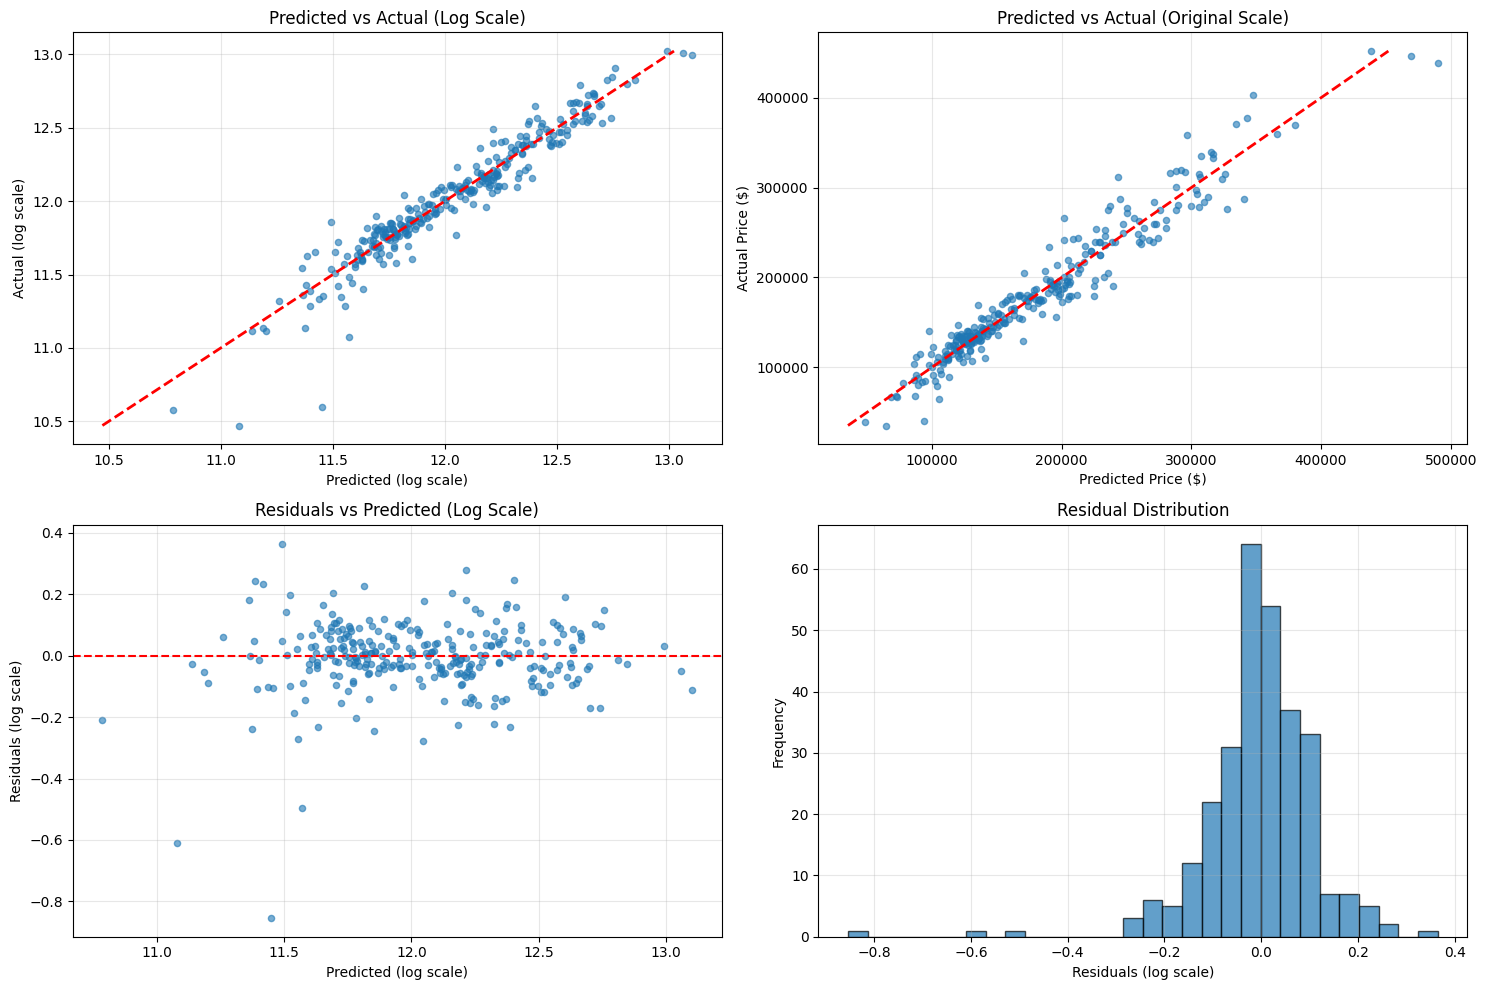

Residual Normality Test: statistic=154.3081, p-value=0.0000
Normal distribution: No
Mean residual: -0.005865
Residual std: 0.1176


In [22]:
print("\nResidual Analysis:")

residuals_log = y_val - val_predictions_log
residuals_original = y_val_original - val_predictions_original

# Create comprehensive residual plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Predicted vs Actual (log scale)
ax1.scatter(val_predictions_log, y_val, alpha=0.6, s=20)
ax1.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
ax1.set_xlabel('Predicted (log scale)')
ax1.set_ylabel('Actual (log scale)')
ax1.set_title('Predicted vs Actual (Log Scale)')
ax1.grid(True, alpha=0.3)

# Predicted vs Actual (original scale)
ax2.scatter(val_predictions_original, y_val_original, alpha=0.6, s=20)
ax2.plot([y_val_original.min(), y_val_original.max()], 
         [y_val_original.min(), y_val_original.max()], 'r--', lw=2)
ax2.set_xlabel('Predicted Price ($)')
ax2.set_ylabel('Actual Price ($)')
ax2.set_title('Predicted vs Actual (Original Scale)')
ax2.grid(True, alpha=0.3)

# Residuals vs Predicted (log scale)
ax3.scatter(val_predictions_log, residuals_log, alpha=0.6, s=20)
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_xlabel('Predicted (log scale)')
ax3.set_ylabel('Residuals (log scale)')
ax3.set_title('Residuals vs Predicted (Log Scale)')
ax3.grid(True, alpha=0.3)

# Residual distribution
ax4.hist(residuals_log, bins=30, alpha=0.7, edgecolor='black')
ax4.set_xlabel('Residuals (log scale)')
ax4.set_ylabel('Frequency')
ax4.set_title('Residual Distribution')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical analysis of residuals
from scipy.stats import normaltest

stat, p_value = normaltest(residuals_log)
print(f"Residual Normality Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Normal distribution: {'Yes' if p_value > 0.05 else 'No'}")
print(f"Mean residual: {residuals_log.mean():.6f}")
print(f"Residual std: {residuals_log.std():.4f}")

The residual plots suggest that the model captures the underlying data structure well, with most predictions closely aligned along the diagonal in both log and original scales. The residuals are mostly centered around zero and show no clear heteroscedasticity or strong pattern against predicted values, which supports the assumption of constant variance.

However, the residual distribution deviates from normality, as confirmed by the normality test (statistic = 154.31, p-value < 0.0001), and the histogram shows a slight left skew. Despite this, the residual mean is close to zero (−0.006), and the standard deviation (0.118) is consistent with the overall RMSE, suggesting no severe bias.

### 5. Feature Importance Analysis
Analyze the importance of features used in the final model to understand which variables contribute most to predictions. This can help validate feature engineering decisions and provide insights into the underlying data relationships.

### 5.1 Permutation Importance Analysis
Assess which features have the greatest impact on the model's performance by measuring the increase in prediction error when each feature’s values are randomly shuffled. This model-agnostic approach offers a robust interpretation of feature relevance and helps validate or challenge assumptions made during feature engineering.

Calculating Permutation Importance for Stacking_Ensemble...
✓ Permutation importance calculated successfully
  Repeats: 5
  Features analyzed: 191

Top 15 Features by Permutation Importance:
Feature                   Importance   Std       
--------------------------------------------------
GrLivArea                 0.0200       0.0010    
OverallQual               0.0125       0.0007    
OverallCond               0.0035       0.0002    
TotalFlrSF                0.0034       0.0002    
LotArea                   0.0030       0.0003    
HouseAge                  0.0030       0.0003    
BsmtFinSF                 0.0025       0.0003    
TotalBaths                0.0017       0.0002    
YearsSinceRemodel         0.0014       0.0001    
SaleCondition_Normal      0.0012       0.0002    
KitchenQual               0.0011       0.0002    
Functional                0.0007       0.0002    
GarageAge                 0.0007       0.0001    
LotFrontage               0.0007       0.0001    
BsmtUnfS

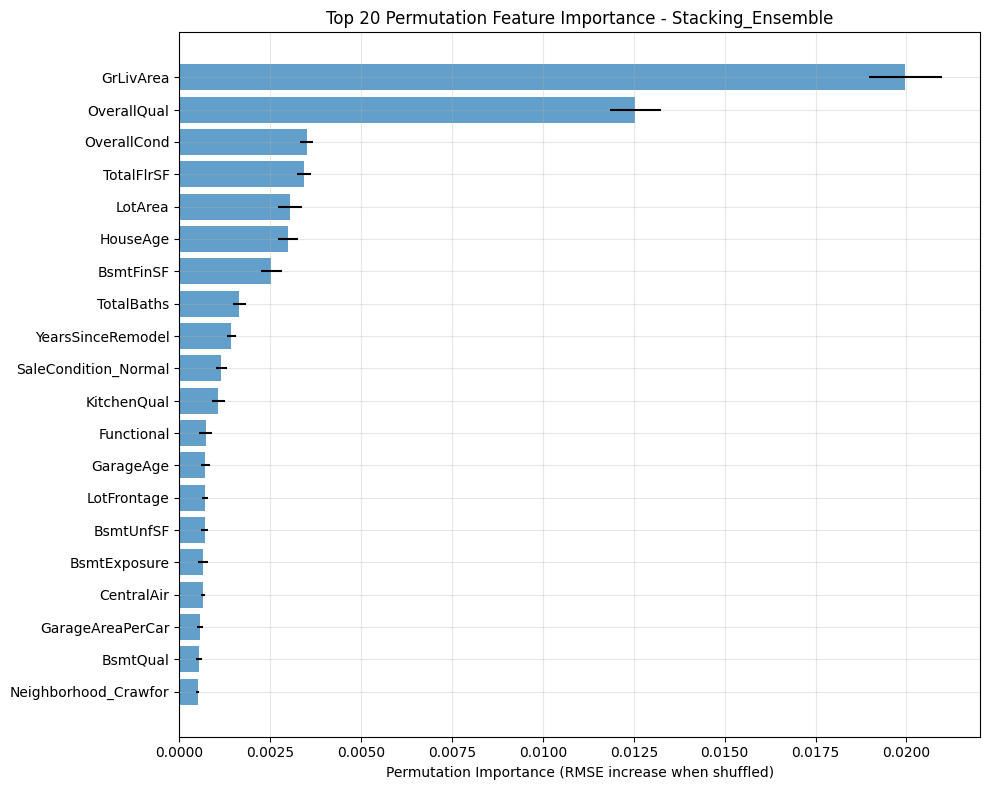

In [38]:
def get_permutation_importance(model, X_train, X_val, y_val, model_name="Model", n_repeats=5):
    """
    Calculate permutation importance for any model
    Works by shuffling each feature and measuring performance drop
    """
    print(f"Calculating Permutation Importance for {model_name}...")
    
    try:
        from sklearn.inspection import permutation_importance
        
        # Calculate permutation importance
        perm_importance = permutation_importance(
            model, X_val, y_val,
            n_repeats=n_repeats,
            random_state=42,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        
        # Create results dataframe
        perm_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Permutation_Importance': perm_importance.importances_mean,
            'Permutation_Std': perm_importance.importances_std
        }).sort_values('Permutation_Importance', ascending=False)
        
        print("✓ Permutation importance calculated successfully")
        print(f"  Repeats: {n_repeats}")
        print(f"  Features analyzed: {len(X_train.columns)}")
        
        # Display top features
        print("\nTop 15 Features by Permutation Importance:")
        print(f"{'Feature':<25} {'Importance':<12} {'Std':<10}")
        print("-" * 50)
        for idx, row in perm_df.head(15).iterrows():
            print(f"{row['Feature']:<25} {row['Permutation_Importance']:<12.4f} {row['Permutation_Std']:<10.4f}")
        
        # Plot
        plt.figure(figsize=(10, 8))
        top_features = perm_df.head(20)
        
        # Bar plot with error bars
        plt.barh(range(len(top_features)), top_features['Permutation_Importance'], 
                xerr=top_features['Permutation_Std'], alpha=0.7)
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('Permutation Importance (RMSE increase when shuffled)')
        plt.title(f'Top 20 Permutation Feature Importance - {model_name}')
        plt.gca().invert_yaxis()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return perm_df
        
    except ImportError:
        print("sklearn.inspection not available. Update scikit-learn:")
        print("pip install --upgrade scikit-learn")
        return None
    except Exception as e:
        print(f"Permutation importance calculation failed: {e}")
        return None

# Usage:
perm_importance = get_permutation_importance(final_model, X_train, X_val, y_val, final_model_name)

GrLivArea emerged as the most influential feature, with a substantial impact on prediction accuracy when shuffled. Other key predictors included OverallQual, OverallCond, and TotalFlrSF. The top features align well with domain expectations, indicating the model’s reliance on both size and quality-related attributes. Most other features showed relatively modest importance, suggesting a smaller marginal contribution to overall predictive performance.

### 5.2 Correlation Importance Analysis
Compute the linear correlation between each feature and the target variable to identify features with strong direct or inverse relationships. Unlike permutation importance, this method is model-agnostic and does not reflect interaction effects or non-linear dependencies.

Calculating Correlation Importance for Stacking_Ensemble...
✓ Correlation importance calculated successfully
  Method: pearson
  Features analyzed: 191
  Strongest correlation: 0.8214

Top 15 Features by Correlation Importance:
Feature                   Correlation  Abs_Corr  
--------------------------------------------------
OverallQual               0.8214       0.8214    
TotalFlrSF                0.7444       0.7444    
GrLivArea                 0.7374       0.7374    
ExterQual                 0.6822       0.6822    
TotalBaths                0.6767       0.6767    
KitchenQual               0.6700       0.6700    
BsmtQual                  0.6169       0.6169    
HouseAge                  -0.6084      0.6084    
GarageFinish              0.6056       0.6056    
YearsSinceRemodel         -0.5685      0.5685    
FireplaceQu               0.5468       0.5468    
TotRmsAbvGrd              0.5421       0.5421    
Foundation_PConc          0.5312       0.5312    
Fireplaces           

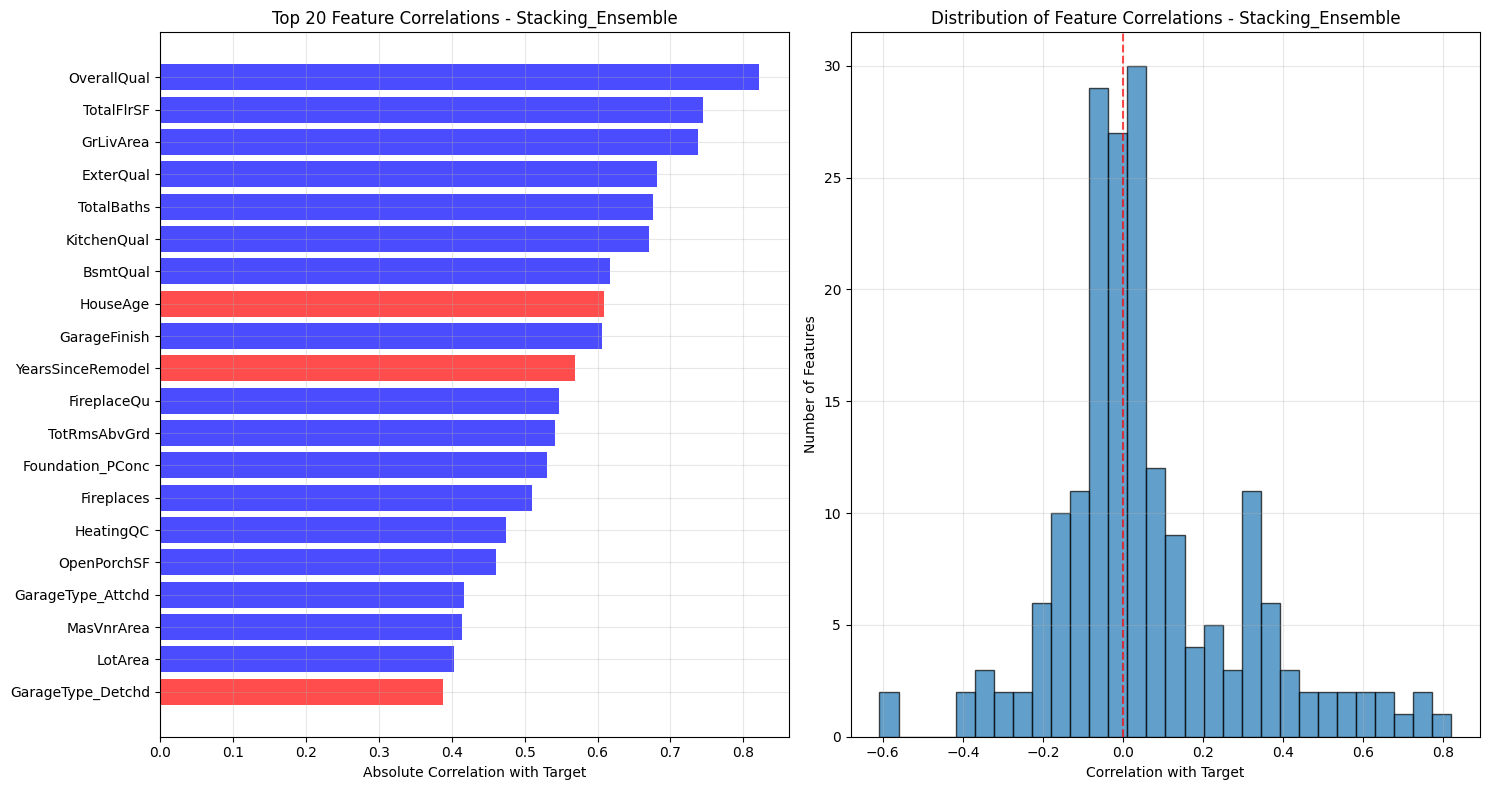


Correlation Summary:
  Positive correlations: 104
  Negative correlations: 87
  Strong correlations (|r| > 0.3): 41


In [50]:
def get_correlation_importance(X_train, y_train, model_name="Model", method='pearson'):
    """
    Calculate correlation-based feature importance
    Simple but fast method showing linear relationships with target
    """
    print(f"Calculating Correlation Importance for {model_name}...")
    
    try:
        # Calculate correlations
        if method == 'pearson':
            correlations = X_train.corrwith(y_train)
        elif method == 'spearman':
            correlations = X_train.corrwith(y_train, method='spearman')
        else:
            print(f"Unknown method {method}, using pearson")
            correlations = X_train.corrwith(y_train)
        
        # Create results dataframe
        corr_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Correlation': correlations.values,
            'Abs_Correlation': np.abs(correlations.values)
        }).sort_values('Abs_Correlation', ascending=False)
        
        # Remove any NaN correlations
        corr_df = corr_df.dropna()
        
        print("✓ Correlation importance calculated successfully")
        print(f"  Method: {method}")
        print(f"  Features analyzed: {len(corr_df)}")
        print(f"  Strongest correlation: {corr_df['Abs_Correlation'].max():.4f}")
        
        # Display top features
        print("\nTop 15 Features by Correlation Importance:")
        print(f"{'Feature':<25} {'Correlation':<12} {'Abs_Corr':<10}")
        print("-" * 50)
        for idx, row in corr_df.head(15).iterrows():
            print(f"{row['Feature']:<25} {row['Correlation']:<12.4f} {row['Abs_Correlation']:<10.4f}")
        
        # Plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
        
        # Plot 1: Top absolute correlations
        top_features = corr_df.head(20)
        colors = ['red' if x < 0 else 'blue' for x in top_features['Correlation']]
        
        ax1.barh(range(len(top_features)), top_features['Abs_Correlation'], color=colors, alpha=0.7)
        ax1.set_yticks(range(len(top_features)))
        ax1.set_yticklabels(top_features['Feature'])
        ax1.set_xlabel('Absolute Correlation with Target')
        ax1.set_title(f'Top 20 Feature Correlations - {model_name}')
        ax1.invert_yaxis()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Correlation distribution
        ax2.hist(corr_df['Correlation'], bins=30, alpha=0.7, edgecolor='black')
        ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7)
        ax2.set_xlabel('Correlation with Target')
        ax2.set_ylabel('Number of Features')
        ax2.set_title(f'Distribution of Feature Correlations - {model_name}')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Additional insights
        positive_corr = (corr_df['Correlation'] > 0).sum()
        negative_corr = (corr_df['Correlation'] < 0).sum()
        strong_corr = (corr_df['Abs_Correlation'] > 0.3).sum()
        
        print(f"\nCorrelation Summary:")
        print(f"  Positive correlations: {positive_corr}")
        print(f"  Negative correlations: {negative_corr}")
        print(f"  Strong correlations (|r| > 0.3): {strong_corr}")
        
        return corr_df
        
    except Exception as e:
        print(f"Correlation importance calculation failed: {e}")
        return None

# Usage:
corr_importance = get_correlation_importance(X_train, y_log, final_model_name, method='pearson')

The correlation analysis revealed that OverallQual (correlation: 0.82), TotalFlrSF (0.74), and GrLivArea (0.73) are the most strongly positively correlated features with the target variable. A total of 41 features show strong correlations (|r| > 0.3), with a roughly even split between positive (104) and negative (87) relationships. This indicates that both linear positive and inverse associations exist across the feature set. The histogram confirms a concentration of weakly correlated features around zero, with a few features demonstrating meaningful linear influence on house prices.

#### Summary of Feature Importance Analysis
While the permutation importance analysis emphasized GrLivArea, OverallQual, and OverallCond as the most critical features based on their actual impact on model performance, the correlation analysis similarly highlighted OverallQual, TotalFlrSF, and GrLivArea as the most linearly associated with the target.

This overlap suggests that these top features are not only statistically correlated with house prices but also practically important for prediction within the final model. However, some features—like OverallCond—ranked highly in permutation importance despite having weaker correlation, indicating that their predictive value may stem from nonlinear interactions or interdependencies the model captures.

## 6. Final Test Predictions
### 6.1 Test Set Prediction Generation
6.1 Test Set Prediction Generation
The final stacked ensemble model is trained on the full training data and used to predict house prices in the test set. Predictions are converted from log scale to the original price scale using the exponential function. Descriptive statistics and sanity checks are applied to ensure prediction values are reasonable and align with the distribution of the training data.

In [51]:
print("\n" + "="*60)
print("GENERATING FINAL TEST PREDICTIONS")
print("="*60)


# Fit final model on complete training data
final_model.fit(X_train, y_log)

# Generate predictions on test set
test_predictions_log = final_model.predict(X_test)
test_predictions_original = np.exp(test_predictions_log)

print(f"Test predictions generated: {len(test_predictions_original)} samples")

# Prediction statistics
print(f"\nPrediction Statistics:")
print(f"  Range: ${test_predictions_original.min():,.0f} - ${test_predictions_original.max():,.0f}")
print(f"  Mean: ${test_predictions_original.mean():,.0f}")
print(f"  Median: ${np.median(test_predictions_original):,.0f}")
print(f"  Std: ${test_predictions_original.std():,.0f}")

# Sanity checks
print(f"\nSanity Checks:")
negative_count = (test_predictions_original < 0).sum()
low_count = (test_predictions_original < 10000).sum()
high_count = (test_predictions_original > 500000).sum()

print(f"  Negative predictions: {negative_count}")
print(f"  Very low predictions (<$10k): {low_count}")
print(f"  Very high predictions (>$500k): {high_count}")

# Compare with training distribution
train_mean = np.exp(y_log).mean()
test_mean = test_predictions_original.mean()
difference_pct = abs(test_mean - train_mean) / train_mean * 100

print(f"  Training mean: ${train_mean:,.0f}")
print(f"  Test prediction mean: ${test_mean:,.0f}")
print(f"  Difference: {difference_pct:.1f}%")

if difference_pct > 20:
    print("  WARNING: Large difference between train and test means")
else:
    print("  Distribution similarity: Good")


GENERATING FINAL TEST PREDICTIONS
Test predictions generated: 1459 samples

Prediction Statistics:
  Range: $47,690 - $701,555
  Mean: $178,964
  Median: $156,005
  Std: $79,131

Sanity Checks:
  Negative predictions: 0
  Very low predictions (<$10k): 0
  Very high predictions (>$500k): 7
  Training mean: $180,933
  Test prediction mean: $178,964
  Difference: 1.1%
  Distribution similarity: Good


The final model generated 1,459 test predictions with a mean of $178,964 and a range from $47,690 to $701,555. No negative or unrealistically low values were produced, and only 7 predictions exceeded $500,000. The test prediction mean is within 1.1% of the training mean ($180,933), indicating good consistency between the two distributions. These results confirm the model’s stability and generalization performance.

### 6.2 Submission File Creation
Create a a submission file with predictions, including validation checks to ensure the format meets the kaggle competition requirements.

In [52]:
# Create submission DataFrame
submission = pd.DataFrame({
    'Id': range(1461, 1461 + len(test_predictions_original)),
    'SalePrice': test_predictions_original
})

# Create submission filename
submission_filename = f'../submissions/submission_{final_model_name}6.csv'

# Save submission
submission.to_csv(submission_filename, index=False)

print(f"\nSubmission File Created:")
print(f"  Filename: {submission_filename}")
print(f"  Shape: {submission.shape}")

# Display submission preview
print(f"\nSubmission Preview:")
print(submission.head(10))
print("...")
print(submission.tail(5))

# Validate submission format
print(f"\nSubmission Validation:")
print(f"  IDs start at: {submission['Id'].min()}")
print(f"  IDs end at: {submission['Id'].max()}")
print(f"  ID count: {len(submission)}")
print(f"  Expected count: {len(X_test)}")
print(f"  Format valid: {len(submission) == len(X_test) and submission['Id'].min() == 1461}")


Submission File Created:
  Filename: ../submissions/submission_Stacking_Ensemble6.csv
  Shape: (1459, 2)

Submission Preview:
     Id      SalePrice
0  1461  115545.419014
1  1462  160534.686069
2  1463  181487.844246
3  1464  193782.818349
4  1465  192528.835989
5  1466  170491.926518
6  1467  171739.099485
7  1468  162240.787803
8  1469  185267.697244
9  1470  119970.695634
...
        Id      SalePrice
1454  2915   84378.882645
1455  2916   82832.341501
1456  2917  160069.446514
1457  2918  116028.023343
1458  2919  216451.375678

Submission Validation:
  IDs start at: 1461
  IDs end at: 2919
  ID count: 1459
  Expected count: 1459
  Format valid: True


## 7. Results Summary and Analysis
### 7.1 Performance Summary
Create a summary of modeling pipeline results.

In [54]:
print("\n" + "="*100)
print("FINAL MODELING RESULTS SUMMARY")
print("="*100)

print(f"Final Model: {final_model_name}")
print(f"Final CV RMSE: {final_model_rmse:.4f}")
print(f"Validation RMSE: {val_rmse_log:.4f}")

# Performance progression analysis
if baseline_results:
    baseline_rmse = best_baseline[1]['cv_rmse_mean']
    individual_best = min(optimized_results.items(), key=lambda x: x[1]['cv_rmse_mean'])
    individual_improvement = (baseline_rmse - individual_best[1]['cv_rmse_mean']) / baseline_rmse * 100
    final_improvement = (baseline_rmse - final_model_rmse) / baseline_rmse * 100
    
    print(f"\nPerformance Progression:")
    print(f"  Best baseline: {baseline_rmse:.4f}")
    print(f"  Best individual: {individual_best[1]['cv_rmse_mean']:.4f} ({individual_improvement:+.2f}%)")
    print(f"  Final ensemble: {final_model_rmse:.4f} ({final_improvement:+.2f}%)")

# Development statistics
print(f"\nModel Development Statistics:")
print(f"  Baseline models tested: {len(baseline_models)}")
print(f"  Hyperparameter optimization trials: {total_trials}")
print(f"  Ensemble methods tested: {len(ensemble_results)}")
print(f"  Total models evaluated: {len(all_model_results)}")

# Validation metrics summary
print(f"\nFinal Model Validation (Original Scale):")
print(f"  RMSE: ${val_rmse_original:,.0f}")
print(f"  MAE: ${val_mae_original:,.0f}")
print(f"  R² Score: {val_r2:.4f}")
print(f"  MAPE: {percentage_errors.mean():.2f}%")

print(f"\nSubmission Details:")
print(f"  File: {submission_filename}")
print(f"  Predictions: {len(test_predictions_original)}")
print(f"  Price range: ${test_predictions_original.min():,.0f} - ${test_predictions_original.max():,.0f}")


FINAL MODELING RESULTS SUMMARY
Final Model: Stacking_Ensemble
Final CV RMSE: 0.1114
Validation RMSE: 0.1176

Performance Progression:
  Best baseline: 0.1166
  Best individual: 0.1143 (+2.00%)
  Final ensemble: 0.1114 (+4.51%)

Model Development Statistics:
  Baseline models tested: 8
  Hyperparameter optimization trials: 415
  Ensemble methods tested: 3
  Total models evaluated: 11

Final Model Validation (Original Scale):
  RMSE: $18,713
  MAE: $13,499
  R² Score: 0.9366
  MAPE: 8.18%

Submission Details:
  File: ../submissions/submission_Stacking_Ensemble6.csv
  Predictions: 1459
  Price range: $47,690 - $701,555


The final model, a stacking ensemble, achieved a cross-validated RMSE of 0.1114, improving by +4.51% over the best baseline. A total of 11 models were evaluated, including 415 hyperparameter tuning trials and 3 ensemble strategies.

On the validation set (original scale), the model delivered strong performance with:
- RMSE: $18,713
- MAE: $13,499
- R² Score: 0.9366
- MAPE: 8.18%

These results indicate that the model generalizes well and produces reliable predictions across a realistic price range from $47,690 to $701,555.

### 7.2 Key Insights and Learnings
Analyze results to extract actionable insights about model performance, ensemble effectiveness, and algorithm ranking to understand what worked best in this specific problem context.

In [55]:
print(f"\nKey Insights:")

# Model performance insights
print(f"1. Best Model Types:")
top_3_models_final = sorted(all_model_results.items(), key=lambda x: x[1]['cv_rmse_mean'])[:3]
for i, (name, result) in enumerate(top_3_models_final, 1):
    print(f"   {i}. {name}: {result['cv_rmse_mean']:.4f}")

# Ensemble effectiveness
if optimized_results and ensemble_results:
    individual_best_rmse = min(optimized_results.values(), key=lambda x: x['cv_rmse_mean'])['cv_rmse_mean']
    ensemble_best_rmse = min(ensemble_results.values(), key=lambda x: x['cv_rmse_mean'])['cv_rmse_mean']
    ensemble_improvement = (individual_best_rmse - ensemble_best_rmse) / individual_best_rmse * 100
    
    print(f"\n2. Ensemble Effectiveness:")
    print(f"   Best individual: {individual_best_rmse:.4f}")
    print(f"   Best ensemble: {ensemble_best_rmse:.4f}")
    if ensemble_improvement > 0:
        print(f"   Ensemble improvement: {ensemble_improvement:.2f}%")
    else:
        print(f"   Ensemble did not improve over best individual model")

# Algorithm performance ranking
print(f"\n3. Algorithm Performance Ranking:")
algorithm_performance = {}
for name, result in optimized_results.items():
    algorithm = name.replace('_Optimized', '')
    algorithm_performance[algorithm] = result['cv_rmse_mean']

for i, (algorithm, rmse) in enumerate(sorted(algorithm_performance.items(), key=lambda x: x[1]), 1):
    print(f"   {i}. {algorithm}: {rmse:.4f}")


Key Insights:
1. Best Model Types:
   1. Stacking_Ensemble: 0.1114
   2. Simple_Ensemble: 0.1117
   3. Weighted_Ensemble: 0.1117

2. Ensemble Effectiveness:
   Best individual: 0.1143
   Best ensemble: 0.1114
   Ensemble improvement: 2.57%

3. Algorithm Performance Ranking:
   1. CatBoost: 0.1143
   2. XGBoost: 0.1148
   3. LightGBM: 0.1172
   4. Lasso: 0.1175
   5. ElasticNet: 0.1175
   6. Ridge: 0.1218
   7. GradientBoosting: 0.1227
   8. RandomForest: 0.1412


CatBoost showed the strongest performance among individual models with a CV RMSE of 0.1143. Ensemble methods performed slightly better, with the Stacking Ensemble achieving the lowest RMSE of 0.1114, corresponding to a 2.57% improvement over the best individual model.
The results indicate that ensemble techniques can contribute to modest performance gains. The algorithm ranking highlights variation in model performance, with tree-based methods generally performing better than linear approaches in this setup.

## 8. Export Models

### 8.1 Create Models Directory


In [58]:
import os
import joblib
import json
from pathlib import Path

# Create models directory
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

print(f"Models directory created: {models_dir}")

Models directory created: ../models


### 8.2 Export Individual Models

In [59]:
def save_model_with_metadata(model, model_name, result_dict, models_dir='../models'):
    """
    Save a model with its performance metadata
    """
    models_path = Path(models_dir)

    # Save the model
    model_file = models_path / f"{model_name}.joblib"
    joblib.dump(model, model_file)

    # Save metadata
    metadata = {
        'model_name': model_name,
        'cv_rmse_mean': result_dict['cv_rmse_mean'],
        'cv_rmse_std': result_dict['cv_rmse_std'],
        'val_rmse': result_dict.get('val_rmse', None),
        'best_params': result_dict.get('best_params', None),
        'model_type': type(model).__name__
    }

    metadata_file = models_path / f"{model_name}_metadata.json"
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"✓ Saved {model_name}: {model_file}")
    print(f"  CV RMSE: {result_dict['cv_rmse_mean']:.4f}")

# Export all optimized individual models
individual_models = {
    'Ridge_Optimized': (best_ridge, ridge_result),
    'Lasso_Optimized': (best_lasso, lasso_result),
    'ElasticNet_Optimized': (best_elasticnet, elasticnet_result),
    'RandomForest_Optimized': (best_rf, rf_result),
    'GradientBoosting_Optimized': (best_gb, gb_result),
    'XGBoost_Optimized': (best_xgb, xgb_result),
    'CatBoost_Optimized': (best_catboost, catboost_result),
    'LightGBM_Optimized': (best_lightgbm, lightgbm_result)
}

print("Exporting individual models...")
for model_name, (model, result) in individual_models.items():
    save_model_with_metadata(model, model_name, result)

Exporting individual models...
✓ Saved Ridge_Optimized: ../models/Ridge_Optimized.joblib
  CV RMSE: 0.1218
✓ Saved Lasso_Optimized: ../models/Lasso_Optimized.joblib
  CV RMSE: 0.1175
✓ Saved ElasticNet_Optimized: ../models/ElasticNet_Optimized.joblib
  CV RMSE: 0.1175
✓ Saved RandomForest_Optimized: ../models/RandomForest_Optimized.joblib
  CV RMSE: 0.1412
✓ Saved GradientBoosting_Optimized: ../models/GradientBoosting_Optimized.joblib
  CV RMSE: 0.1227
✓ Saved XGBoost_Optimized: ../models/XGBoost_Optimized.joblib
  CV RMSE: 0.1148
✓ Saved CatBoost_Optimized: ../models/CatBoost_Optimized.joblib
  CV RMSE: 0.1143
✓ Saved LightGBM_Optimized: ../models/LightGBM_Optimized.joblib
  CV RMSE: 0.1172


### 8.3 Export Ensemble Models

In [60]:
def save_ensemble_model(ensemble, ensemble_name, result_dict, component_models=None, models_dir='../models'):
    """
    Save an ensemble model with its components and metadata
    """
    models_path = Path(models_dir)

    # Save the ensemble model
    ensemble_file = models_path / f"{ensemble_name}.joblib"
    joblib.dump(ensemble, ensemble_file)

    # Save metadata
    metadata = {
        'ensemble_name': ensemble_name,
        'cv_rmse_mean': result_dict['cv_rmse_mean'],
        'cv_rmse_std': result_dict['cv_rmse_std'],
        'val_rmse': result_dict.get('val_rmse', None),
        'ensemble_type': type(ensemble).__name__,
        'component_models': component_models or []
    }

    metadata_file = models_path / f"{ensemble_name}_metadata.json"
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"✓ Saved {ensemble_name}: {ensemble_file}")
    print(f"  CV RMSE: {result_dict['cv_rmse_mean']:.4f}")

# Export ensemble models
ensemble_models = {
    'Simple_Ensemble': (simple_ensemble, simple_result, ['CatBoost', 'XGBoost', 'LightGBM', 'Lasso']),
    'Weighted_Ensemble': (weighted_ensemble, weighted_result, ['CatBoost', 'XGBoost', 'LightGBM', 'Lasso']),
    'Stacking_Ensemble': (stacking_ensemble, stacking_result, ['CatBoost', 'XGBoost', 'LightGBM', 'Lasso'])
}

print("\nExporting ensemble models...")
for ensemble_name, (ensemble, result, components) in ensemble_models.items():
    save_ensemble_model(ensemble, ensemble_name, result, components)


Exporting ensemble models...
✓ Saved Simple_Ensemble: ../models/Simple_Ensemble.joblib
  CV RMSE: 0.1117
✓ Saved Weighted_Ensemble: ../models/Weighted_Ensemble.joblib
  CV RMSE: 0.1117
✓ Saved Stacking_Ensemble: ../models/Stacking_Ensemble.joblib
  CV RMSE: 0.1114


### 8.4 Export Final Model

In [64]:
# Export the final selected model
final_model_metadata = {
    'final_model_name': final_model_name,
    'final_cv_rmse': final_model_rmse,
    'selection_criteria': 'Best cross-validation RMSE',
    'exported_at': str(pd.Timestamp.now())
}

models_path = Path(models_dir)

# Save final model
final_model_file = models_path / "final_model.joblib"
joblib.dump(final_model, final_model_file)

# Save final model metadata
final_metadata_file = models_path / "final_model_metadata.json"
with open(final_metadata_file, 'w') as f:
    json.dump(final_model_metadata, f, indent=2)

print(f"\n✓ Final model saved: {final_model_file}")
print(f"  Model: {final_model_name}")
print(f"  CV RMSE: {final_model_rmse:.4f}")



✓ Final model saved: ../models/final_model.joblib
  Model: Stacking_Ensemble
  CV RMSE: 0.1114


### 8.4 Create Model Summary

In [65]:
model_summary = {
    'project_info': {
        'dataset': 'House Prices - Advanced Regression Techniques',
        'target': 'SalePrice (log-transformed)',
        'features': X_train.shape[1],
        'training_samples': X_train.shape[0],
        'test_samples': X_test.shape[0]
    },
    'individual_models': {},
    'ensemble_models': {},
    'final_model': final_model_metadata,
    'performance_comparison': {}
}

# Add individual model performance
for model_name, (model, result) in individual_models.items():
    model_summary['individual_models'][model_name] = {
        'cv_rmse_mean': result['cv_rmse_mean'],
        'cv_rmse_std': result['cv_rmse_std'],
        'model_type': type(model).__name__
    }

# Add ensemble model performance
for ensemble_name, (ensemble, result, components) in ensemble_models.items():
    model_summary['ensemble_models'][ensemble_name] = {
        'cv_rmse_mean': result['cv_rmse_mean'],
        'cv_rmse_std': result['cv_rmse_std'],
        'components': components
    }

# Add performance comparison
all_results = {**{name: result for name, (model, result) in individual_models.items()},
               **{name: result for name, (ensemble, result, components) in ensemble_models.items()}}

for model_name, result in sorted(all_results.items(), key=lambda x: x[1]['cv_rmse_mean']):
    model_summary['performance_comparison'][model_name] = result['cv_rmse_mean']

# Save model summary
summary_file = models_path / "model_summary.json"
with open(summary_file, 'w') as f:
    json.dump(model_summary, f, indent=2)

print(f"\n✓ Model summary saved: {summary_file}")


✓ Model summary saved: ../models/model_summary.json
